## Run first

In [2]:
# Run first
import pickle
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import chart_studio.plotly as py
# import plotly.express as px
import pandas as pd
# import cufflinks as cf
import json as js
# cf.go_offline()
# cf.set_config_file(offline=False, world_readable=True)
import itertools
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# init_notebook_mode(connected=False)
# import plotly.io as pio
# pio.renderers.default = 'notebook_connected'
import os
import action_selection as asl
from itertools import product, repeat
import jsonpickle as pickle
import jsonpickle.ext.numpy as jsonpickle_numpy
import json
# import plotly.graph_objects as go
import perception as prc
import agent as agt
from environment import PlanetWorld
from agent import BayesianPlanner
from world import World
from planet_sequences import generate_trials_df
from multiprocessing import Pool
import time
%matplotlib inline

# functions
def load_file_names(arrays, use_fitting=False):
    lst = []
    for i in product(*arrays):
        lst.append(list(i))
    
    names = []
    print('files to load: ' + str(len(lst)))
    for li, l in enumerate(lst):

        prefix = ''
        if use_fitting == True:
            prefix += 'fitt_'
        else:
            prefix +='hier_'

        if l[0] == True:
            prefix += 'switch1_'
        else:
            prefix +='switch0_'

        if l[1] == True:
            prefix += 'degr1_'
        else:
            prefix += 'degr0_'

        fname = prefix + 'p' + str(l[4])  +'_learn_rew' + str(int(l[2] == True))+ '_q' + str(l[3]) + '_h' + str(l[5]) + '_' +\
        str(l[8]) + '_' + str(l[6]) + str(l[7])+ '_dec' + str(l[9])
        # print(len(l))
        if len(l) > 10:
            fname += '_' + l[-1]
        
        fname +=  '_extinguish.json'

        names.append(fname)


    return names
def load_df(names,data_folder='data', extinguish=None):
    if extinguish is None:
        raise('did not specify if rewarded during extinction')
    # if not just_simulated:
    path = os.path.join(os.getcwd(),data_folder)
    #     names = os.listdir(path)
    for fi, f in enumerate(names):
        names[fi] = os.path.join(path,f)
        # print(names[fi])

    dfs = [None]*len(names)

    for f,fname in enumerate(names):
        jsonpickle_numpy.register_handlers()
        with open(fname, 'r') as infile:
            data = json.load(infile)
        worlds = pickle.decode(data)
        meta = worlds[-1]
        agents = [w.agent for w in worlds[:-1]]
        perception = [w.agent.perception for w in worlds[:-1]]
        nt = worlds[0].T
        npl = perception[0].npl
        nr = worlds[0].agent.nr
        nc = perception[0].nc
        nw = len(worlds[:-1])
        ntrials = meta['trials']
        learn_rew = np.repeat(meta['learn_rew'], ntrials*nw*nt)
        switch_cues = np.repeat(meta['switch_cues'], ntrials*nw*nt)
        contingency_degradation = np.repeat(meta['contingency_degradation'], ntrials*nw*nt)
        ntrials_df = np.repeat(meta['trials_per_block'], ntrials*nw*nt)
        ndb = np.repeat(meta['degradation_blocks'], ntrials*nw*nt)
        ntb = np.repeat(meta['training_blocks'], ntrials*nw*nt)
        post_dir_rewards = [a.posterior_dirichlet_rew for a in agents]
        post_dir_rewards = [post[:,1:,:,:] for post in post_dir_rewards]
        entropy_rewards = np.zeros([nw*ntrials*nt,nc])
        extinguished = np.zeros(ntrials*nw*nt, dtype='int32')
        extinguished[:] = int(extinguish == True)
        
        for ip, post in enumerate(post_dir_rewards):
            post = post.sum(axis=3)
            norm = post.sum(axis=2)
            reward_distributions = np.zeros(post.shape)

            for r in range(nr):
                reward_distributions[:,:,r,:] = np.divide(post[:,:,r,:],norm)
            entropy = np.zeros([ntrials, nt, nc])

            for trl in range(ntrials):
                for t in range(nt-1):
                    prob = reward_distributions[trl,t,:,:].T
                    # if prob.sum() == 0:
                    #     print('problem')
                    entropy[trl,t+1,:] = -(np.log(prob)*prob).sum(axis=1)

            entropy[:,0,:] = None
            entropy_rewards[ip*(ntrials*nt):(ip+1)*(ntrials*nt),:] = np.reshape(entropy, [ntrials*nt,nc])

        entropy_context = np.zeros(ntrials*nt*nw)
        post_context = [a.posterior_context for a in agents]

        for ip, post in enumerate(post_context):
            entropy = np.zeros([ntrials, nt])

            for trl in range(ntrials):
                entropy[trl,:] = -(np.log(post[trl,:])*post[trl,:]).sum(axis=1) 
            entropy_context[ip*(ntrials*nt):(ip+1)*(ntrials*nt)] = np.reshape(entropy, [ntrials*nt])

        posterior_context = [agent.posterior_context for agent in agents]
        observations = [w.observations for w in worlds[:-1]]
        context_cues = worlds[0].environment.context_cues
        policies = worlds[0].agent.policies
        actions = [w.actions[:,:3] for w in worlds[:-1]] 
        true_optimal = np.tile(np.repeat(meta['optimal_sequence'],nt), nw)
        cue = np.tile(np.repeat(context_cues, nt), nw)
        ex_p = np.zeros(ntrials)
        executed_policy = np.zeros(nw*ntrials,dtype='int32')
        optimality = np.zeros(nw*ntrials)
        chose_optimal = np.zeros(nw*ntrials)

        for w in range(nw):
            for pi, p in enumerate(policies):
                inds = np.where( (actions[w][:,0] == p[0]) & (actions[w][:,1] == p[1]) & (actions[w][:,2] == p[2]) )[0]
                ex_p[inds] = pi
            executed_policy[w*ntrials:(w+1)*ntrials] = ex_p
            ch_op = executed_policy[w*ntrials:(w+1)*ntrials] == meta['optimal_sequence']
            chose_optimal[w*ntrials:(w+1)*ntrials] = ch_op
            optimality[w*ntrials:(w+1)*ntrials] = np.cumsum(ch_op)/(np.arange(ntrials)+1)

        executed_policy = np.repeat(executed_policy, nt)
        chose_optimal = np.repeat(chose_optimal, nt)
        optimality = np.repeat(optimality, nt)
        no = perception[0].generative_model_context.shape[0]
        optimal_contexts = [np.argmax(perception[0].generative_model_contexts[i,:] for i in range(no))]
        true_context = 0
        q = np.repeat(meta['context_trans_prob'], ntrials*nw*nt)
        p = np.repeat(meta['cue_ambiguity'], ntrials*nw*nt)
        h = np.repeat(meta['h'], ntrials*nw*nt)
        dec_temp = np.repeat(worlds[0].dec_temp,ntrials*nw*nt)
        switch_cues = np.repeat(meta['switch_cues'], ntrials*nw*nt)
        learn_rew = np.repeat(meta['learn_rew'], ntrials*nw*nt)
        degradation = np.repeat('contingency_degradation', ntrials*nw*nt)
        trial_type = np.tile(np.repeat(meta['trial_type'], nt), nw)
        trial = np.tile(np.repeat(np.arange(ntrials),nt), nw)
        run = np.repeat(np.arange(nw),nt*ntrials)
        run.astype('str')
        inferred_context_t0 = np.zeros(ntrials*nw,dtype='int32')
        inferred_context_t3  = np.zeros(ntrials*nw,'int32')
        agnt = np.repeat(np.arange(nw)+f*nw,nt*ntrials)
        no, nc = perception[0].generative_model_context.shape 
        modes_gmc =  perception[0].generative_model_context.argsort(axis=1)
        contexts = [modes_gmc[i,:][-2:] for i in range(no)] # arranged in ascending order!
        if_inferred_context_switch = np.zeros(ntrials, dtype="int32")

        for i in range(no):    
            c = np.array([contexts[i][-1]]*(meta['trials_per_block']*meta['training_blocks'])\
                + [contexts[i][-2]]*(meta['trials_per_block']*meta['degradation_blocks'])\
                + [contexts[i][-1]]*meta['trials_per_block']*2)
            if_inferred_context_switch[np.where(context_cues == i)] = c[np.where(context_cues == i)]
        inferred_switch = np.zeros(ntrials*nw,dtype='int32')
        context_optimality = np.zeros(ntrials*nw)

        for w in range(nw):
            inferred_context_t0[w*ntrials:(w+1)*ntrials] = np.argmax(posterior_context[w][:,0,:],axis=1)
            inferred_context_t3[w*ntrials:(w+1)*ntrials] = np.argmax(posterior_context[w][:,-1,:],axis=1)
            inferred_switch[w*ntrials:(w+1)*ntrials] = if_inferred_context_switch == \
                                                    inferred_context_t3[w*ntrials:(w+1)*ntrials]
            context_optimality[w*ntrials:(w+1)*ntrials] = np.cumsum(inferred_switch[w*ntrials:(w+1)*ntrials])\
                                                                /(np.arange(ntrials)+1)
    
        inferred_switch = np.repeat(inferred_switch, nt)
        inferred_context_t0 = np.repeat(inferred_context_t0, nt)
        inferred_context_t3 = np.repeat(inferred_context_t3, nt)
        context_optimality = np.repeat(context_optimality, nt)
        t = np.tile(np.arange(4), nw*ntrials)
        
        d = {'trial_type':trial_type, 'run':run, 'trial':trial, 't':t, 'true_optimal':true_optimal,\
                            'cue':cue, 'q':q, 'p':p, 'h':h, 'inferred_context_t0':inferred_context_t0,\
                            'inferred_context_t3':inferred_context_t3, 'executed_policy':executed_policy,\
                            'chose_optimal': chose_optimal, 'entropy_rew_c1': entropy_rewards[:,0], 'entropy_rew_c2': entropy_rewards[:,1], \
                            'entropy_rew_c3': entropy_rewards[:,2] , 'entropy_rew_c4': entropy_rewards[:,3],\
                            'policy_optimality':optimality,'agent':agnt, 'inferred_switch': inferred_switch,\
                            'context_optimality':context_optimality, 'learn_rew': learn_rew, 'entropy_context':entropy_context, \
                            'switch_cues':switch_cues, 'contingency_degradation': contingency_degradation,\
                            'degradation_blocks': ndb, 'training_blocks':ntb, 'trials_per_block': ntrials_df, "dec_temp":dec_temp} 

        # for key in d.keys():
        #     print(key, np.unique(d[key].shape))
        dfs[f] = pd.DataFrame(d)
        
    data = pd.concat(dfs)

    groups = ['agent','run', 't','degradation_blocks', 'training_blocks', 'trials_per_block','learn_rew', 'p', 'q','h','cue']
    grouped = data.groupby(by=groups)
    data['iterator'] = 1
    data['ith_cue_trial'] = grouped['iterator'].transform('cumsum')
    data['policy_optimality_cue'] = grouped['chose_optimal'].transform('cumsum') / data['ith_cue_trial']
    data['context_optimal_cue'] = grouped['inferred_switch'].transform('cumsum') / data['ith_cue_trial']
    data.drop('iterator',1,inplace =True)
    data.astype({'h': 'category'})

    return data


def context_plot(query='p == 0.6'):

    # context and policy optimality
    fig = plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    print('cue')
    plot_df = base_df.query(query + '& t ==' + str(t) + ' & cue == ' + str(cue))
    plot_df['h'] = plot_df['h'].astype('category')
    ax = sns.lineplot(data=plot_df, x='trial', y='context_optimality', hue='h',\
                      palette=sns.color_palette('Blues_r',n_colors=np.unique(plot_df['h']).size), legend=False)
    ax.set(ylim = (0,1.1))
    ranges = plot_df.groupby('trial_type')['trial'].agg(['min', 'max'])
    cols = [[1,1,1], [0,0,0],[1,1,1]] 
    for i, row in ranges.iterrows():
        ax.axvspan(xmin=row['min'], xmax=row['max'], facecolor=cols[i], alpha=0.05)
    # reward distribution entropy for different contexts
    plt.subplot(1,2,2)
    ax = sns.lineplot(data=plot_df, x='trial', y='policy_optimality', hue='h',\
            palette=sns.color_palette('Blues_r',n_colors=np.unique(plot_df['h']).size))
    ax.legend(ncol = np.unique(plot_df['h']).size, bbox_to_anchor=(-2, -0.25), loc='upper left',\
              borderaxespad=0,title='h')
    cols = [[1,1,1], [0,0,0],[1,1,1]] 
    for i, row in ranges.iterrows():
        ax.axvspan(xmin=row['min'], xmax=row['max'], facecolor=cols[i], alpha=0.05)

    ax.set(ylim = (0,1))
    # title = base_query + ' & ' + query
    # title = title.replace(' & ', ', ')
    # title = title.replace('==', ':')
    title = 'Inferred context and policy optimality for p: ' + query[-3:] + ', switch cues: '\
            + str(int(switch)) + ', degradation: ' + str(int(contingency_degr)) + \
            ', reward_naive: ' + str(int(reward_naive)) + ', cue_shown: ' + str(cue)
    fig.suptitle(title, fontsize=15)



def reward_entropy_plot(query='p == 0.6'):

    # entropy of reward distribution for each context 
    plot_df = base_df.query(query + '& t ==' + str(t) + ' & cue == ' + str(cue))
    plot_df['h'] = plot_df['h'].astype('category')
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(11, 7))
    axs_flat = axs.flatten()
    ranges = plot_df.groupby('trial_type')['trial'].agg(['min', 'max'])

    legs = [False, False, False, True]
    ys = ['entropy_rew_c1', 'entropy_rew_c2','entropy_rew_c3','entropy_rew_c4',]
    for c in range(nc):
        sns.lineplot(ax=axs_flat[c], data=plot_df, x='trial',y=ys[c],hue='h',\
            palette=sns.color_palette('Blues_r',n_colors=np.unique(plot_df['h']).size), legend=legs[c])
        cols = [[1,1,1], [0,0,0],[1,1,1]]
        for i, row in ranges.iterrows():
            axs_flat[c].axvspan(xmin=row['min'], xmax=row['max'], facecolor=cols[i], alpha=0.05)
        axs_flat[-1].legend(ncol = np.unique(plot_df['h']).size, bbox_to_anchor=(-2, -0.25), loc='upper left',\
                            borderaxespad=0.5,title='h')
    
    title = 'Reward distribution entropy for  p: ' + query[-3:] + ', switch cues: ' + str(int(switch)) +\
            ', degradation: ' + str(int(contingency_degr)) + ', reward_naive: ' + str(int(reward_naive)) + \
            ', cue_shown: ' + str(cue)
    fig.suptitle(title, fontsize=15)

def context_plot_cue_dependent(query='p == 0.6'):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,6), sharex = True)

    lgnd = [False, True]
    cues = [0,1]
    titles_c = ['Inferred context optimality for cue 0','Inferred context optimality (at t4) for cue 1']
    titles_p = ['Inferred policy optimality for cue 0','Inferred policy optimality for cue 1']

    for cue in cues:
        plot_df = base_df.query(query + '& t ==' + str(t) + ' & cue == ' + str(cue))

        sns.lineplot(ax = axes[0,cue], data=plot_df, x='trial', y='context_optimal_cue', hue='h',\
                      palette=sns.color_palette('Blues_r',n_colors=np.unique(plot_df['h']).size),legend=False)
        axes[0,cue].set_title(titles_c[cue])
        axes[1,cue].set_title(titles_p[cue])
        sns.lineplot(ax=axes[1,cue], data=plot_df, x='trial', y='policy_optimality_cue', hue='h',\
            palette=sns.color_palette('Blues_r',n_colors=np.unique(plot_df['h']).size), legend=lgnd[cue])
    axes[1,1].legend(ncol = np.unique(plot_df['h']).size, bbox_to_anchor=(-2, -0.25), loc='upper left',\
              borderaxespad=0,title='h')
    ranges = plot_df.groupby('trial_type')['trial'].agg(['min', 'max'])
    cols = [[1,1,1], [0,0,0],[1,1,1]] 
    for ax in axes.flatten():
        for i, row in ranges.iterrows():
            ax.axvspan(xmin=row['min'], xmax=row['max'], facecolor=cols[i], alpha=0.05)
    


    # title = base_query + ' & ' + query
    # title = title.replace(' & ', ', ')
    # title = title.replace('==', ':')
    title = 'p: ' + query[-3:] + ', switch cues: '\
            + str(int(switch)) + ', degradation: ' + str(int(contingency_degr)) + \
            ', reward_naive: ' + str(int(reward_naive))
    fig.suptitle(title, fontsize=15)


def load_df_animation_context(names,data_folder='temp'):

    path = os.path.join(os.getcwd(),data_folder)
    #     names = os.listdir(path)

    for fi, f in enumerate(names):
        names[fi] = os.path.join(path,f)

    print(names)
    overall_df = [None for _ in range(len(names))]
    for f,fname in enumerate(names):
        jsonpickle_numpy.register_handlers()

        with open(fname, 'r') as infile:
            data = json.load(infile)

        worlds = pickle.decode(data)
        meta = worlds[-1]
        nw = len(worlds[:-1])
        agents = [w.agent for w in worlds[:-1]]
        posterior_context = [agent.posterior_context for agent in agents]
        ntrials, t, nc = posterior_context[0].shape
        outcome_surprise = [agent.outcome_suprise for agent in agents]
        policy_surprise = [agent.policy_surprise for agent in agents]
        policy_entropy = [agent.policy_entropy for agent in agents]
        npi = agents[0].posterior_policies.shape[2]
        taus = np.arange(ntrials)
        ts = np.arange(t)
        cs = np.arange(nc)
        pis_post = np.array(['post_' for _ in range(npi)], dtype=object) + np.array([str(i) for i in range(npi)], dtype=object)
        pis_prior = np.array(['post_' for _ in range(npi)], dtype=object) + np.array([str(i) for i in range(npi)], dtype=object)
        pis_like = np.array(['post_' for _ in range(npi)], dtype=object) + np.array([str(i) for i in range(npi)], dtype=object)

        mi = pd.MultiIndex.from_product([taus, ts, cs], names=['trial', 't', 'context'])
        mi_post = pd.MultiIndex.from_product([taus, ts, pis_post, cs], names=['trial', 't', 'policy','context'])
        mi_like = pd.MultiIndex.from_product([taus, ts, pis_like, cs], names=['trial', 't', 'policy','context'])
        mi_prior = pd.MultiIndex.from_product([taus, ts, pis_like, cs], names=['trial', 't', 'policy','context'])

        dfs = [None for _ in range(nw)]
        factor = ntrials*nc*t

        for w in range(nw):

            policy_post_df =  pd.Series(index=mi_post, data=agents[w].posterior_policies.flatten())
            policy_post_df = policy_post_df.unstack(level='policy').reset_index()
            # fix entropy calcs
            policy_prob = policy_post_df.iloc[:,-8:].to_numpy()
            policy_prob[policy_prob == 0] = 10**(-300)
            entropy = -(policy_prob*np.log(policy_prob)).sum(axis=1)

            prior_policies = np.tile(agents[w].prior_policies[:,np.newaxis,:,:], (1,t,1,1))
            # print(np.all(prior_policies[:,0,:,:] == prior_policies[:,1,:,:] ))
            policy_prior_df =  pd.Series(index=mi_prior, data=prior_policies.flatten())
            policy_prior_df = policy_prior_df.unstack(level='policy').reset_index()

            policy_like_df =  pd.Series(index=mi_like, data=agents[w].likelihood.flatten())
            policy_like_df = policy_like_df.unstack(level='policy').reset_index()
            
            policy_entropy_df = pd.Series(index=mi,\
                data=policy_entropy[w].flatten()).reset_index().rename(columns = {0:'policy_entropy'})
            
            policy_surprise_df = pd.Series(index=mi,\
                data=policy_surprise[w].flatten()).reset_index().rename(columns = {0:'context_obs_surprise'})
            outcome_surprise_df = pd.Series(index=mi,\
                data=outcome_surprise[w].flatten()).reset_index().rename(columns = {0:'outcome_surprise'})
                
            # break
            df = pd.Series(index=mi, data=posterior_context[w].flatten())
            df = df.reset_index().rename(columns = {0:'probability'})
            df['context_obs_surprise'] = policy_surprise_df['context_obs_surprise']
            df['outcome_surprise'] = outcome_surprise_df['outcome_surprise']
            df['policy_entropy'] = policy_entropy_df['policy_entropy']
            # df['policy_entropy'] = policy_entropy_df['policy_entropy']
            df['learn_rew'] = np.repeat(meta['learn_rew'], factor)
            df['switch_cues'] = np.repeat(meta['switch_cues'], factor)
            df['contingency_degradation'] = np.repeat(meta['contingency_degradation'], factor)
            df['trials_per_block'] = np.repeat(meta['trials_per_block'], factor)
            df['degradation_blocks'] = np.repeat(meta['degradation_blocks'], factor)
            df['training_blocks'] = np.repeat(meta['training_blocks'], factor)
            df['context_cues'] = np.repeat(worlds[0].environment.context_cues, nc*t)
            df['true_optimal'] = np.repeat(meta['optimal_sequence'], nc*t)
            df['q'] = np.repeat(meta['context_trans_prob'], factor)
            df['p'] = np.repeat(meta['cue_ambiguity'], factor)
            df['h'] = np.repeat(meta['h'], factor)
            df['run'] = np.repeat(w,factor)
            df['trial_type'] = np.repeat(meta['trial_type'], nc*t)
            df['trial'] = np.repeat(np.arange(ntrials), nc*t)
            df['agent'] = np.repeat(w+f*nw,factor)
            df = df.join(policy_post_df.iloc[:,-8:])
            dfs[w] = df
            break
        overall_df[f] = pd.concat(dfs)
    data_animation = pd.concat(overall_df)
    # data_animation.to_excel('data_animation.xlsx')
    return data_animation
# data_animation.to_csv('data_animation.csv')


def load_df_animation_pol(names,data_folder='temp'):

    path = os.path.join(os.getcwd(),data_folder)
    #     names = os.listdir(path)

    for fi, f in enumerate(names):
        names[fi] = os.path.join(path,f)


    overall_df = [None for _ in range(len(names))]
    for f,fname in enumerate(names):
        jsonpickle_numpy.register_handlers()

        with open(fname, 'r') as infile:
            data = json.load(infile)

        worlds = pickle.decode(data)
        meta = worlds[-1]
        nw = len(worlds[:-1])
        agents = [w.agent for w in worlds[:-1]]
        posterior_context = [agent.posterior_context for agent in agents]
        ntrials, t, nc = posterior_context[0].shape
        policy_entropy = [agent.policy_entropy for agent in agents]
        npi = agents[0].posterior_policies.shape[2]
        taus = np.arange(ntrials)
        ts = np.arange(t)
        cs = np.arange(nc)
        pis = np.arange(npi)

        mi = pd.MultiIndex.from_product([taus, ts, pis, cs], names=['trial', 't','policy', 'context'])
        dfs = [None for _ in range(nw)]
        factor = ntrials*nc*t*npi

        for w in range(nw):
            df =  pd.Series(index=mi, data=agents[w].posterior_policies.flatten())
            df = df.reset_index().rename(columns = {0:'policy_post'})

            prior_policies = np.tile(agents[w].prior_policies[:,np.newaxis,:,:], (1,t,1,1))
            policy_prior_df =  pd.Series(index=mi, data=prior_policies.flatten())
            policy_prior_df = policy_prior_df.reset_index().rename(columns = {0:'policy_prior'})

            policy_like_df =  pd.Series(index=mi, data=agents[w].likelihood.flatten())
            policy_like_df = policy_like_df.reset_index().rename(columns = {0:'policy_likelihood'})
            df['policy_prior'] = policy_prior_df['policy_prior']
            df['policy_like'] = policy_like_df['policy_likelihood']
            post_context = np.tile(posterior_context[w][:,:,np.newaxis,:], (1,1,npi,1))
            # print(np.all(post_context[:,:,0,:] == post_context[:,:,3,:]))

            post_context_df = pd.Series(index=mi, data=post_context.flatten())
            post_context_df = post_context_df.reset_index().rename(columns = {0:'post_context'})
            df['post_context'] = post_context_df['post_context']
            df['learn_rew'] = np.repeat(meta['learn_rew'], factor)
            df['switch_cues'] = np.repeat(meta['switch_cues'], factor)
            df['contingency_degradation'] = np.repeat(meta['contingency_degradation'], factor)
            df['trials_per_block'] = np.repeat(meta['trials_per_block'], factor)
            df['degradation_blocks'] = np.repeat(meta['degradation_blocks'], factor)
            df['training_blocks'] = np.repeat(meta['training_blocks'], factor)
            df['context_cues'] = np.repeat(worlds[0].environment.context_cues, nc*t*npi)
            df['true_optimal'] = np.repeat(meta['optimal_sequence'], nc*t*npi)
            df['q'] = np.repeat(meta['context_trans_prob'], factor)
            df['p'] = np.repeat(meta['cue_ambiguity'], factor)
            df['h'] = np.repeat(meta['h'], factor)
            df['run'] = np.repeat(w,factor)
            df['trial_type'] = np.repeat(meta['trial_type'], nc*t*npi)
            df['trial'] = np.repeat(np.arange(ntrials), nc*t*npi)
            df['agent'] = np.repeat(w+f*nw,factor)
            dfs[w] = df

        overall_df[f] = pd.concat(dfs)
    data_animation = pd.concat(overall_df)
    # data_animation.to_excel('data_animation.xlsx')
    return data_animation


def load_df_reward_dkl(names,data_folder='temp',nc=4):

    path = os.path.join(os.getcwd(),data_folder)
    #     names = os.listdir(path)

    for fi, f in enumerate(names):
        names[fi] = os.path.join(path,f)

    dfs = [None]*len(names)

    planet_reward_probs = np.array([[0.95, 0   , 0   ],
                            [0.05, 0.95, 0.05],
                            [0,    0.05, 0.95]])  

    planet_reward_probs_switched = np.array([[0   , 0    , 0.95],
                                            [0.05, 0.95 , 0.05],
                                            [0.95, 0.05 , 0.0]])
    
    planet_reward_probs = np.tile(planet_reward_probs[:,:,np.newaxis], (1,1,nc))
    planet_reward_probs_switched = np.tile(planet_reward_probs_switched[:,:,np.newaxis], (1,1,nc))

    overall_df = [None for _ in range(len(names))]

    for f,fname in enumerate(names):
        jsonpickle_numpy.register_handlers()
        with open(fname, 'r') as infile:
            data = json.load(infile)
                         
        worlds = pickle.decode(data)
        meta = worlds[-1]
        agents = [w.agent for w in worlds[:-1]]
        perception = [w.agent.perception for w in worlds[:-1]]
        reward_probs = [agent.posterior_dirichlet_rew for agent in agents]
        
        nt = worlds[0].T
        npl = perception[0].npl
        nr = worlds[0].agent.nr
        nc = perception[0].nc
        nw = len(worlds[:-1])
        ntrials = meta['trials']

        learn_rew = np.repeat(meta['learn_rew'], ntrials*nw*nt)
        switch_cues = np.repeat(meta['switch_cues'], ntrials*nw*nt)
        contingency_degradation = np.repeat(meta['contingency_degradation'], ntrials*nw*nt)
        ntrials_df = np.repeat(meta['trials_per_block'], ntrials*nw*nt)
        ndb = np.repeat(meta['degradation_blocks'], ntrials*nw*nt)
        ntb = np.repeat(meta['training_blocks'], ntrials*nw*nt)
        post_dir_rewards = [a.posterior_dirichlet_rew for a in agents]
        post_dir_rewards = [post[:,1:,:,:] for post in post_dir_rewards]
        entropy_rewards = np.zeros([nw*ntrials*nt,nc])
        extinguished = np.zeros(ntrials*nw*nt, dtype='int32')
        extinguished[:] = int(extinguish == True)
        
        # define true distribution reward
        if f == 0:
            tpb = meta['trials_per_block']
            db = meta['degradation_blocks']
            tb = meta['training_blocks']
            p= np.tile(planet_reward_probs[np.newaxis,np.newaxis,:,:,:], (ntrials, nt, 1,1,1))
            p[tb*tpb:(tb+db)*tpb,:,:,:,:] = \
                np.tile(planet_reward_probs_switched[np.newaxis,np.newaxis,:,:,:],
                       ((db + tb)*tpb - tb*tpb, nt, 1,1,1))
            p[p == 0] = 10**(-300)
        else:
            pass

        factor = ntrials*nt*nc
        taus = np.arange(ntrials)
        ts = np.arange(nt)
        # npls = np.char.add(np.asarray(['pl_' for _ in range(npl)]), np.asarray([str(i) for i in range(npl)]))
        npls = np.arange(npl)
        nrs = np.arange(nr)
        cs = np.arange(nc)
        mi = pd.MultiIndex.from_product([taus, ts, npls, cs],
                names=['trial', 't', 'planet', 'context'])
        # dfs_dkl = [None for _ in range(nw)]
        # factor = ntrials*nt*nr*npl*nc

        dkl_df = [None for _ in range(nw)]
        for w in range(nw):
            q = reward_probs[w]
            e = (db+tb)*tpb
            q[e:,:,:,:,:] = np.tile(q[e-1,:,:,:,:], (2*tpb,1,1,1,1))
            q[q == 0] = 10**(-300)
            norm = 1/(q.sum(axis=2))
            q = np.einsum('etrpc, etpc -> etrpc', q, norm)
            dkl = (q*np.log(q/p)).sum(axis=2)
            df =  pd.Series(index=mi, data=dkl.flatten())
            df = df.unstack(level = 'planet')
            df = df.reset_index().rename(columns = {0:'p0_dkl', 1:'p1_dkl', 2:'p2_dkl'})
            df['avg_dkl'] = (df['p0_dkl'] + df['p1_dkl'] + df['p2_dkl'])/3
            df['learn_rew'] = np.repeat(meta['learn_rew'], factor)
            df['switch_cues'] = np.repeat(meta['switch_cues'], factor)
            df['contingency_degradation'] = np.repeat(meta['contingency_degradation'], factor)
            df['trials_per_block'] = np.repeat(meta['trials_per_block'], factor)
            df['degradation_blocks'] = np.repeat(meta['degradation_blocks'], factor)
            df['training_blocks'] = np.repeat(meta['training_blocks'], factor)
            df['context_cues'] = np.repeat(worlds[0].environment.context_cues, nc*nt)
            df['true_optimal'] = np.repeat(meta['optimal_sequence'], nc*nt)
            df['q'] = np.repeat(meta['context_trans_prob'], factor)
            df['p'] = np.repeat(meta['cue_ambiguity'], factor)
            df['h'] = np.repeat(meta['h'], factor)
            df['run'] = np.repeat(w,factor)
            df['trial_type'] = np.repeat(meta['trial_type'], nc*nt)
            df['trial'] = np.repeat(np.arange(ntrials), nc*nt)
            df['agent'] = np.repeat(w+f*nw,factor)
            dkl_df[w] = df
        #     break
        # break
        overall_df[f] = pd.concat(dkl_df)
    data = pd.concat(overall_df)
    return data


def explore_counts(names,data_folder='temp',nc=4):

    path = os.path.join(os.getcwd(),data_folder)
    #     names = os.listdir(path)

    for fi, f in enumerate(names):
        names[fi] = os.path.join(path,f)

    dfs = [None]*len(names)

    planet_reward_probs = np.array([[0.95, 0   , 0   ],
                            [0.05, 0.95, 0.05],
                            [0,    0.05, 0.95]])  

    planet_reward_probs_switched = np.array([[0   , 0    , 0.95],
                                            [0.05, 0.95 , 0.05],
                                            [0.95, 0.05 , 0.0]])
    
    planet_reward_probs = np.tile(planet_reward_probs[:,:,np.newaxis], (1,1,nc))
    planet_reward_probs_switched = np.tile(planet_reward_probs_switched[:,:,np.newaxis], (1,1,nc))

    overall_df = [None for _ in range(len(names))]

    for f,fname in enumerate(names):
        jsonpickle_numpy.register_handlers()
        with open(fname, 'r') as infile:
            data = json.load(infile)
                         
        worlds = pickle.decode(data)
        meta = worlds[-1]
        agents = [w.agent for w in worlds[:-1]]
        perception = [w.agent.perception for w in worlds[:-1]]
        reward_probs = [agent.posterior_dirichlet_rew for agent in agents]
        
        nt = worlds[0].T
        npl = perception[0].npl
        nr = worlds[0].agent.nr
        nc = perception[0].nc
        nw = len(worlds[:-1])
        ntrials = meta['trials']

        learn_rew = np.repeat(meta['learn_rew'], ntrials*nw*nt)
        switch_cues = np.repeat(meta['switch_cues'], ntrials*nw*nt)
        contingency_degradation = np.repeat(meta['contingency_degradation'], ntrials*nw*nt)
        ntrials_df = np.repeat(meta['trials_per_block'], ntrials*nw*nt)
        ndb = np.repeat(meta['degradation_blocks'], ntrials*nw*nt)
        ntb = np.repeat(meta['training_blocks'], ntrials*nw*nt)
        post_dir_rewards = [a.posterior_dirichlet_rew for a in agents]
        post_dir_rewards = [post[:,1:,:,:] for post in post_dir_rewards]
        entropy_rewards = np.zeros([nw*ntrials*nt,nc])
        extinguished = np.zeros(ntrials*nw*nt, dtype='int32')
        extinguished[:] = int(extinguish == True)
        
        # define true distribution reward
        if f == 0:
            tpb = meta['trials_per_block']
            db = meta['degradation_blocks']
            tb = meta['training_blocks']
            p= np.tile(planet_reward_probs[np.newaxis,np.newaxis,:,:,:], (ntrials, nt, 1,1,1))
            p[tb*tpb:(tb+db)*tpb,:,:,:,:] = \
                np.tile(planet_reward_probs_switched[np.newaxis,np.newaxis,:,:,:],
                       ((db + tb)*tpb - tb*tpb, nt, 1,1,1))
            p[p == 0] = 10**(-300)
        else:
            pass

        factor = ntrials*nt*nc
        taus = np.arange(ntrials)
        ts = np.arange(nt)
        # npls = np.char.add(np.asarray(['pl_' for _ in range(npl)]), np.asarray([str(i) for i in range(npl)]))
        npls = np.arange(npl)
        nrs = np.arange(nr)
        cs = np.arange(nc)
        mi = pd.MultiIndex.from_product([taus, ts, nrs, npls, cs],
                names=['trial', 't', 'rewards','planet', 'context'])

        # dfs_dkl = [None for _ in range(nw)]
        # factor = ntrials*nt*nr*npl*nc

        dkl_df = [None for _ in range(nw)]
        for w in range(nw):
            q = reward_probs[w]
            q[q == 0] = 10**(-300)
            df =  pd.Series(index=mi, data=q.flatten())
            df = df.unstack(level = 'planet')
            df = df.unstack(level = 'rewards')
            # norm = 1/(q.sum(axis=2))
            # q = np.einsumparam_dict('etrpc, etpc -> etrpc', q, norm)
            # dkl = (q*np.log(q/p)).sum(axis=2)
            # df = df.reset_index().rename(columns = {0:'p0_dkl', 1:'p1_dkl', 2:'p2_dkl'})
            # dkl_df[w] = df
            break
        break
    #     overall_df[f] = pd.concat(dkl_df)
    # data = pd.concat(overall_df)

    return df
# df_dkl = load_df_reward_dkl(names)


# df = load_df_animation_pol(names)
# df.head()


### Load Data  <a class="anchor" id="section_3_1"></a>

In [9]:
f = open(os.path.join(os.getcwd(),'config/ordered/config_degradation_1_switch_0_train2_degr2_n70.json'))
data = json.load(f)
df = pd.DataFrame(data)

df.head()

,context,sequence,starts,planets,trial_type,block,degradation_blocks,training_blocks,interlace,contingency_degradation,switch_cues,trials_per_block
0,1,6,3,"[0, 0, 2, 1, 0, 2]",0,0.0,2,2,True,True,False,70
1,0,3,3,"[0, 1, 0, 2, 1, 0]",0,0.0,2,2,True,True,False,70
2,1,6,2,"[0, 0, 2, 1, 1, 0]",0,0.0,2,2,True,True,False,70
3,1,6,2,"[0, 0, 2, 0, 0, 0]",0,0.0,2,2,True,True,False,70
4,0,3,0,"[0, 1, 0, 2, 1, 2]",0,0.0,2,2,True,True,False,70


In [5]:

h =  [1, 2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30,40,50,60,70,80,90,100,200]
# h = [40]
cue_ambiguity = [0.9]                       
context_trans_prob = [0.9]                
degradation = [True]
cue_switch = [False]
reward_naive = [False]
training_blocks = [2]
degradation_blocks=[2]
trials_per_block=[70]
dec_temps = [1,2,3,4,5,6]
conf = ['ordered']

arrays = [cue_switch, degradation, reward_naive, context_trans_prob, cue_ambiguity,h,\
        training_blocks, degradation_blocks, trials_per_block,dec_temps,conf]

extinguish = True
names = load_file_names(arrays)
print(names)
# df = load_df(names, data_folder='temp/old',extinguish=extinguish)
df = load_df(names, data_folder='temp',extinguish=extinguish)
# df_dkl = load_df_reward_dkl(names, data_folder='temp')
df.head()



,trial_type,run,trial,t,true_optimal,cue,q,p,h,inferred_context_t0,...,entropy_context,switch_cues,contingency_degradation,degradation_blocks,training_blocks,trials_per_block,dec_temp,ith_cue_trial,policy_optimality_cue,context_optimal_cue
0,0,0,0,0,6,1,0.9,0.9,1,1,...,0.393661,False,True,2,2,70,1,1,0.0,1.0
1,0,0,0,1,6,1,0.9,0.9,1,1,...,0.393661,False,True,2,2,70,1,1,0.0,1.0
2,0,0,0,2,6,1,0.9,0.9,1,1,...,0.393661,False,True,2,2,70,1,1,0.0,1.0
3,0,0,0,3,6,1,0.9,0.9,1,1,...,0.445602,False,True,2,2,70,1,1,0.0,1.0
4,0,0,1,0,3,0,0.9,0.9,1,0,...,0.276447,False,True,2,2,70,1,1,0.0,1.0


### Policy and context optimality

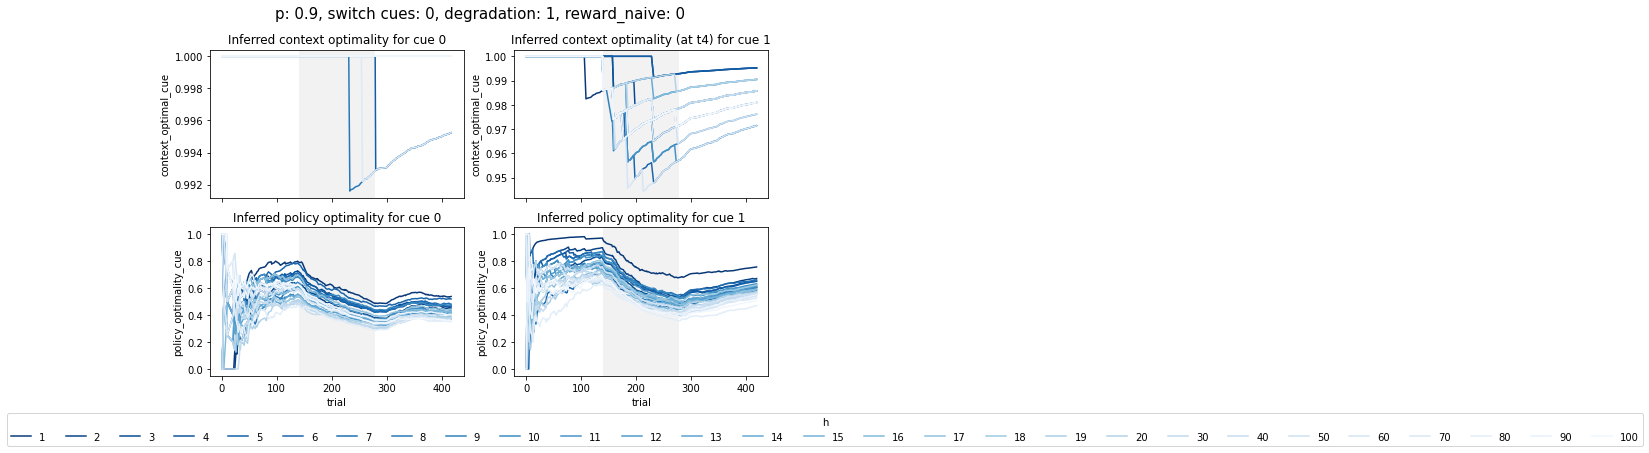

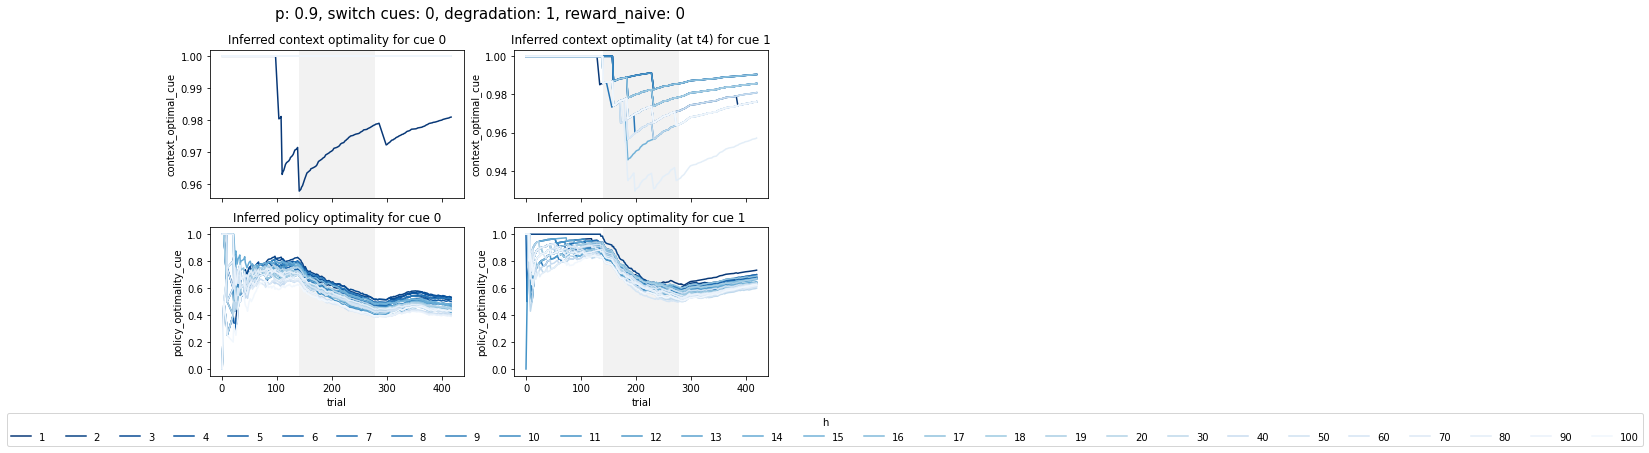

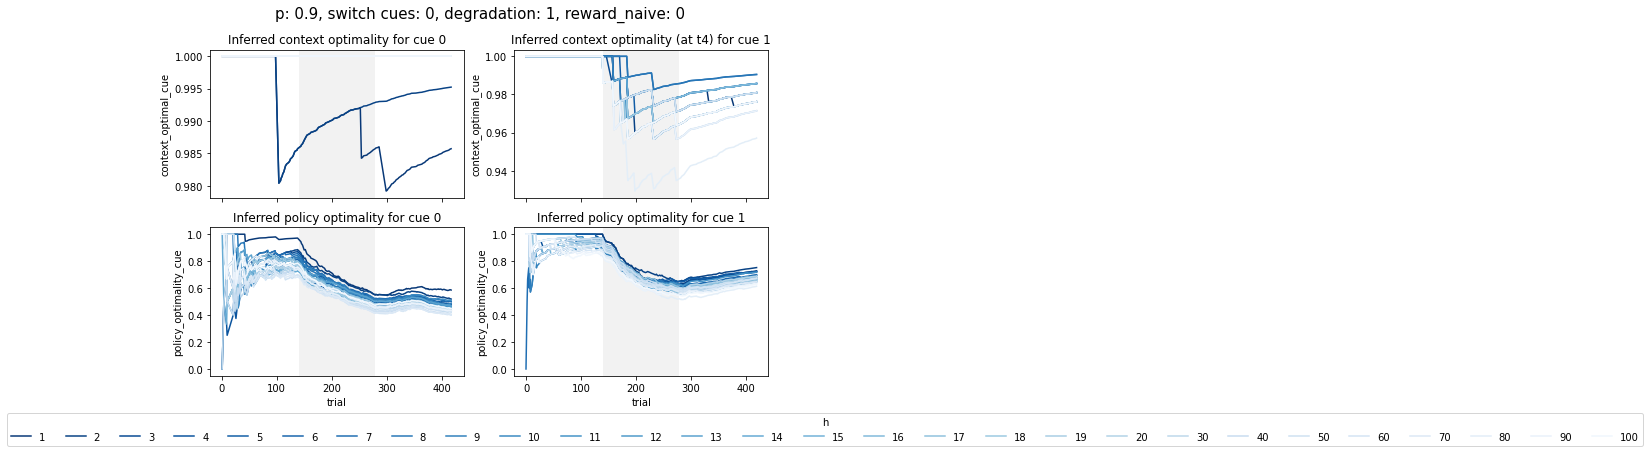

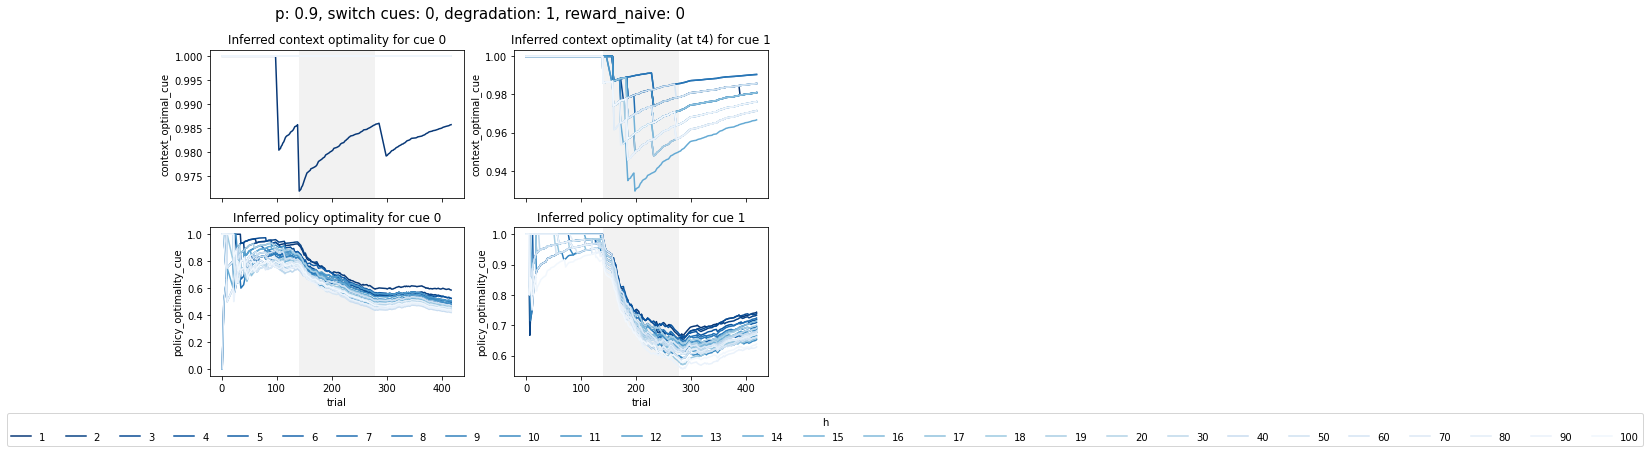

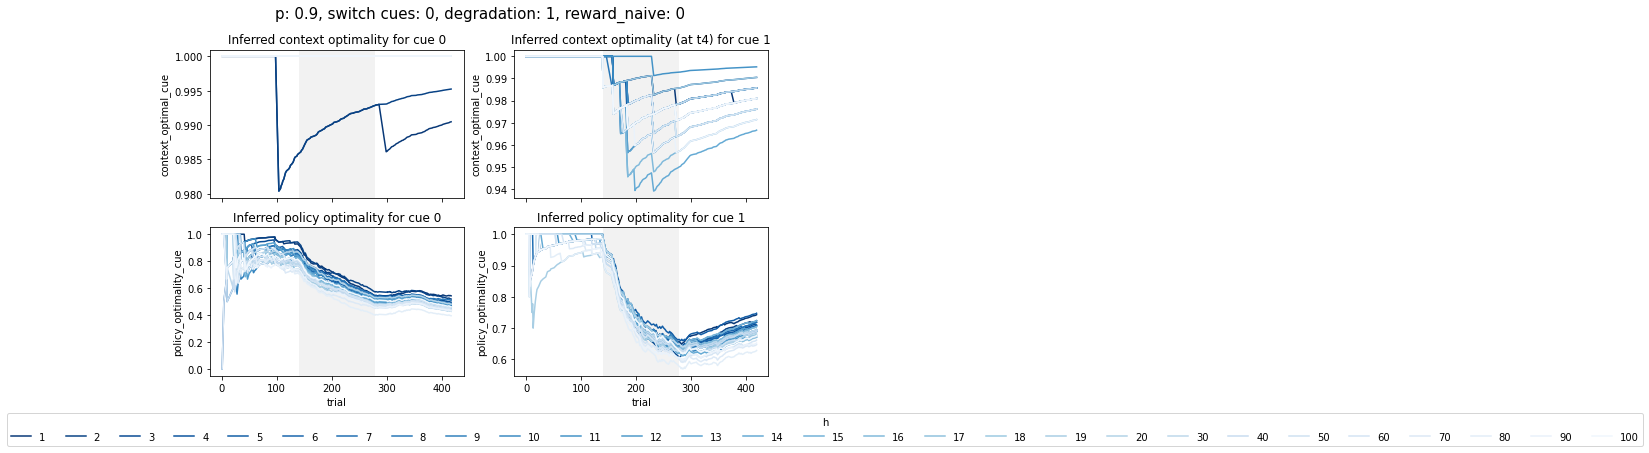

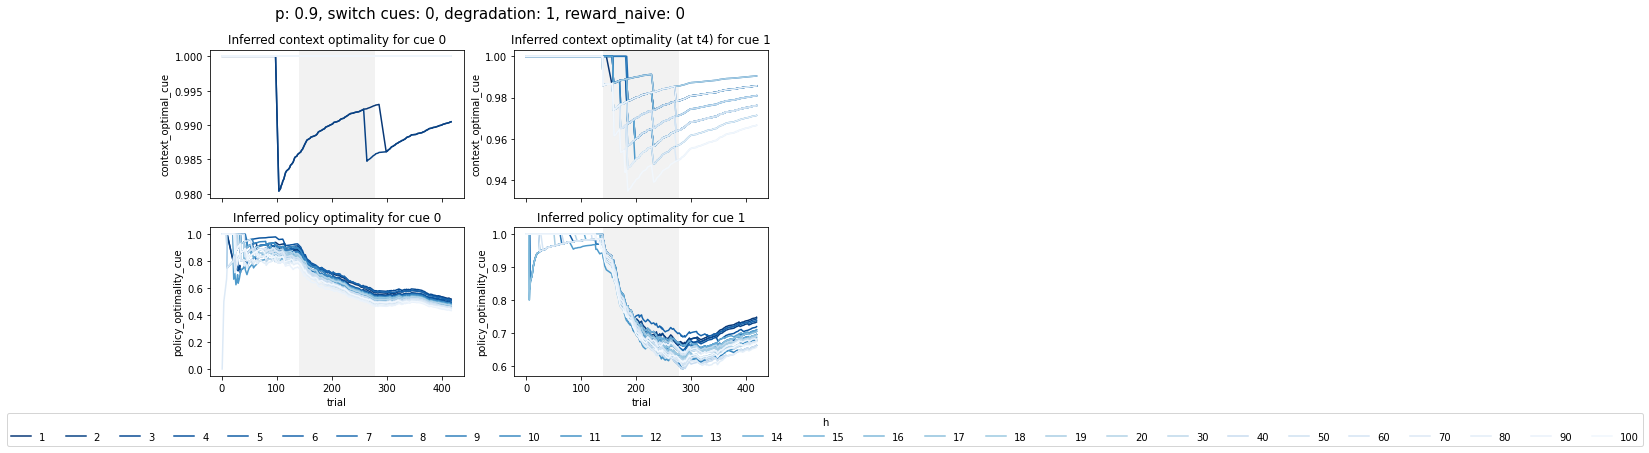

In [6]:
# context plot

# base query parameters
switch = False
contingency_degr = True
reward_naive = False
q = 0.9
h = 100
t = 3
trials_per_block = 70
training_blocks = 2
degradation_blocks = 2
queries = ['p==0.9']
cue = 0
for dec_temp in dec_temps:
    strs = np.array(['switch_cues==', '& contingency_degradation==', '& learn_rew==', '& q==', '& h<=',\
                    '& training_blocks==', '& degradation_blocks==', '& trials_per_block==', '& dec_temp =='],dtype='str')
    vals = np.array([switch, contingency_degr, reward_naive, q, h,\
                    training_blocks, degradation_blocks, trials_per_block, dec_temp], dtype='str')
    whole_query = np.char.join('', np.char.add(strs, vals))
    base_query = ' '.join(whole_query.tolist())
    base_df = df.query(base_query)
    # base_df_dkl = df_dkl.query(base_query)
    # queries = ['p==0.95','p==0.7']
    p = queries[0]
    context_plot_cue_dependent(p)



### Reward distribution DKL

In [ ]:
%matplotlib inline
fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(20,3))
plot_df = base_df_dkl.query('t==3' + ' & p ==' + str(p))
cue
    
for cont in range(4):

    # print('context_cues == ' + str(cue) + ' & context== ' + str(cont))
    if cont == 3:
        sns.lineplot(ax=axes[cont], data=plot_df.query('context== ' + str(cont)),
                    x='trial', y='avg_dkl', hue='h', legend=True, \
                    palette=sns.color_palette('Blues_r',n_colors=np.unique(plot_df['h']).size))
        print(np.unique(plot_df['h']))
        axes[cont].legend(ncol = np.unique(plot_df['h']).size, bbox_to_anchor=(-3.3, -0.3), loc='upper left',\
            borderaxespad=0,title='h')
    else:
        
        sns.lineplot(ax=axes[cont], data=plot_df.query('context== ' + str(cont)),
                    x='trial', y='avg_dkl', hue='h',legend=False,\
                        palette=sns.color_palette('Blues_r',n_colors=np.unique(plot_df['h']).size))
    axes[cont].set_title('context: ' + str(cont))

ranges = plot_df.groupby('trial_type')['trial'].agg(['min', 'max'])
cols = [[1,1,1], [0,0,0],[1,1,1]] 
for ax in axes.flatten():    
    for i, row in ranges.iterrows():
        ax.axvspan(xmin=row['min'], xmax=row['max'], facecolor=cols[i], alpha=0.05) 


# %matplotlib inline
# fig, axes = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(7,10))
# plot_df = base_df_dkl.query('t==3' + ' & p ==' + str(p))

# for cont in range(4):
#     for cue in [0,1]:

#         # print('context_cues == ' + str(cue) + ' & context== ' + str(cont))
#         if cont == 3 and cue ==1:
#             sns.lineplot(ax=axes[cont,cue], data=plot_df.query('context_cues == ' + str(cue) + ' & context== ' + str(cont)),
#                      x='trial', y='avg_dkl', hue='h', legend=True, \
#                      palette=sns.color_palette('Blues_r',n_colors=np.unique(plot_df['h']).size))
#             print(np.unique(plot_df['h']))
#             axes[cont,cue].legend(ncol = np.unique(plot_df['h']).size, bbox_to_anchor=(-1, -1), loc='upper left',\
#               borderaxespad=0,title='h')
#         else:
            
#             sns.lineplot(ax=axes[cont,cue], data=plot_df.query('context_cues == ' + str(cue) + ' & context== ' + str(cont)),
#                      x='trial', y='avg_dkl', hue='h',legend=False,\
#                          palette=sns.color_palette('Blues_r',n_colors=np.unique(plot_df['h']).size))
#         axes[cont,cue].set_title('context: ' + str(cont) + ' cue: ' + str(cue))
# ranges = plot_df.groupby('trial_type')['trial'].agg(['min', 'max'])
# cols = [[1,1,1], [0,0,0],[1,1,1]] 
# for ax in axes.flatten():    
#     for i, row in ranges.iterrows():
#         ax.axvspan(xmin=row['min'], xmax=row['max'], facecolor=cols[i], alpha=0.05) 

Policy optimality zoomed in 

In [ ]:
sns.set_style("whitegrid")
ps = [0.8]
# switch = False
# contingency_degr = True
# q = 0.25-0.1
# h = 200
# t = 3
# trials_per_block = 60
# training_blocks = 4
# degradation_blocks = 4
# strs = np.array(['switch_cues==', '& contingency_degradation==', '& q==', '& h<=',\
#                 '& training_blocks==', '& degradation_blocks==', '& trials_per_block=='],dtype='str')
# vals = np.array([switch, contingency_degr, q, h,\
#                 training_blocks, degradation_blocks, trials_per_block], dtype='str')
# whole_query = np.char.join('', np.char.add(strs, vals))
# base_query = ' '.join(whole_query.tolist())
# base_df = df.query(base_query)

plot_df = base_df.query('trial_type > 0 & trial_type <= 2 &t==0')
plot_df = plot_df.astype({'h': 'category'})
print(plot_df.size)
grouped = plot_df.groupby(by=['agent', 'run','h','cue'])
plot_df['policy_optimality_subset'] = grouped['chose_optimal'].transform('cumsum')
plot_df['offset'] = grouped['ith_cue_trial'].transform('min')
plot_df['policy_optimality_subset'] = plot_df['policy_optimality_subset'] / (plot_df['ith_cue_trial'] - plot_df['offset']+1)
cue_degradation = [1,0]

fig, axes = plt.subplots(ncols=3, nrows=2, figsize = (15,7), sharey=True)
plt.tight_layout()
for cue in [0,1]:
    for pi,p in enumerate(ps):
        if pi == 2 and cue==1:
            sns.lineplot(ax = axes[cue,pi], data=plot_df.query('learn_rew == '+ str(int(reward_naive))  + ' & p==' + str(p) + ' & cue==' + str(cue)),\
                        x = 'trial',y='policy_optimality_subset', hue='h', legend=True)
            axes[cue,pi].set_title('p: ' + str(p) + ' cue: ' + str(cue))
        else:
            sns.lineplot(ax = axes[cue,pi], data=plot_df.query('learn_rew == '+ str(int(reward_naive)) + ' & p==' + str(p) + ' & cue==' + str(cue)),\
                        x = 'trial',y='policy_optimality_subset', hue='h', legend=False)
            axes[cue,pi].set_title('p: ' + str(p) + ' cue: ' + str(cue))

    ranges = plot_df.groupby('trial_type')['trial'].agg(['min', 'max'])
    cols = [[1,1,1], [0,0,0],[1,1,1]] 
    for ax in axes.flatten():
        for i, row in ranges.iterrows():
            ax.axvspan(xmin=row['min'], xmax=row['max'], facecolor=cols[i], alpha=0.05)
 
    ax.legend(bbox_to_anchor=(-2,-0.3), loc='upper left', borderaxespad=0,title='h',ncol=np.unique(plot_df['h'].size))
    # fig.suptitle(ttls[f] + ' and cue_degradation: ' + str(cue_degradation[ci]) , fontsize=15, y=1.08)   
    

## Animation

### Load Data

In [ ]:
nc = 4
extinguish = True
h =  [1,40]
cue_ambiguity = [0.95]                       
context_trans_prob = [0.99]                
degradation = [True]
cue_switch = [False]
rew_naive = [False]
train_blocks = [2]
degr_blocks=[2]
tpb=[70]
dec_temp = [1]
arrays = [cue_switch, degradation, rew_naive, context_trans_prob, cue_ambiguity,h,\
        train_blocks, degr_blocks, tpb, dec_temp]

names = load_file_names(arrays, use_fitting=False)
# df_context = load_df_animation_context(names, data_folder='temp/old')
# df_policy = load_df_animation_pol(names, data_folder='temp/old')
df_context = load_df_animation_context(names, data_folder='temp/fitt_hier')
# df_policy = load_df_animation_pol(names, data_folder='temp/fitt_hier')
# print(np.unique(df_policy['h']).size)

# check if values make sense
# df[['trial','t','policy', 'context','post_context', 'true_optimal','policy_prior', 'policy_like','policy_post']].head(50)

#### Policy Figure

In [ ]:
def animation_figure():
    ##### figure 1
    fig1 = px.line(plot_df, x='policy', y='policy_prior',animation_frame='trial',animation_group='context',\
        color="context",line_dash = 'h', range_y=[0,1])
    fig2 = px.line(plot_df, x='policy', y='policy_like',animation_frame='trial',animation_group='context',\
        color="context",line_dash = 'h', range_y=[0,1])
    fig3 = px.line(plot_df, x='policy', y='policy_post',animation_frame='trial',animation_group='context',\
        color="context",line_dash = 'h', range_y=[0,1])
    fig4 = px.line(base_df.query(trial_que + ' & t==0' + ' & policy==0'),\
        x='context', y='post_context',animation_frame='trial',animation_group='h', color="h", range_y=[0,1])

    # ##### combine

    # integrate the two figures, putting second figure on separate axis

    fig = go.Figure(
        data=[t for t in fig1.data] 
            + [t.update(xaxis="x2", yaxis="y2") for t in fig2.data] 
            + [t.update(xaxis="x3", yaxis="y3") for t in fig3.data] 
            + [t.update(xaxis="x4", yaxis="y4") for t in fig4.data],
        frames=[
            go.Frame(
                name=fr1.name,
                data=[t for t in fr1.data]
                + [t.update(xaxis="x2", yaxis="y2") for t in fr2.data]
                + [t.update(xaxis="x3", yaxis="y3") for t in fr3.data]
                + [t.update(xaxis="x4", yaxis="y4") for t in fr4.data],
            )
            for fr4, fr3, fr2, fr1 in zip(fig4.frames, fig3.frames, fig2.frames, fig1.frames)
        ],
        layout=fig1.layout,
    )


    # now config axes appropriately
    fig.update_layout(
        xaxis_domain=[0, 0.3],
        yaxis_domain=[0, 0.45],
        yaxis_range=[0, 1],

        xaxis2={"domain":[0.33, 0.63], "matches": None, "title":{"text":fig2.layout.xaxis.title.text}},
        yaxis2={"range": [0,1], "domain":[0, 0.45],'position':0.33, "matches":None,"title":{"text":fig2.layout.yaxis.title.text}},

        xaxis3={"domain": [0.66, 1], "matches": None, "title":{"text":fig3.layout.xaxis.title.text}},
        yaxis3={"range": [0,1],"domain":[0, 0.45], "matches": None,'position':0.66, "title":{"text":fig3.layout.yaxis.title.text}},
        xaxis4={"domain": [0, 0.5], "matches": None,"showticklabels":False},
        yaxis4={"range": [0,1], "domain":[0.5, 1], "matches": None, "title":{"text":fig4.layout.yaxis.title.text}},

        showlegend=True,
    )

    for i, frame in enumerate(fig.frames):
        frame.layout.title = "Cue: {}, Trial type: {}".format(cue, trial_type[i])
    for step in fig.layout.sliders[0].steps:
        step["args"][1]["frame"]["redraw"] = True

    fig.show()

switch = cue_switch[0]
contingency_degr = degradation[0]
reward_naive = rew_naive[0]
q = context_trans_prob[0]
h = 1
cue = 0
trials_per_block = tpb[0]
training_blocks = train_blocks[0]
degradation_blocks = degr_blocks[0]
p = cue_ambiguity[0]
strs = np.array(['switch_cues == ', '& contingency_degradation==', '& learn_rew==', '& q==', '& h>=',\
                 '& training_blocks == ', '& degradation_blocks == ', '& trials_per_block ==', '& p =='],dtype='str')
vals = np.array([switch, contingency_degr, reward_naive, q, h,\
                 training_blocks, degradation_blocks, trials_per_block, p], dtype='str')
whole_query = np.char.join('', np.char.add(strs, vals))
base_query = ' '.join(whole_query.tolist())
base_df = df_policy.query(base_query)
# trial_que = 'trial > 200 & trial <300 & context_cues ==' + str(cue)
trial_que = 'trial_type >=0  & context_cues ==' + str(cue)
plot_df = base_df.query(trial_que + ' & t==0' + ' & (context == 0 | context == 2)')
trial_type = plot_df.groupby(by=['trial'])['trial_type'].mean().to_numpy().astype('int32')
print(np.unique(plot_df['h']).size)
animation_figure()
base_query
# cue = 1
# trial_que = 'trial_type >0  & context_cues ==' + str(cue)
# plot_df = base_df.query(trial_que + ' & t==0')
# trial_type = plot_df.groupby(by=['trial'])['trial_type'].mean().to_numpy().astype('int32')

# animation_figure()


In [ ]:
test = plot_df.query('policy==0').set_index(['agent','trial','t','context'])['post_context']
test = test.unstack(level='context').query('trial > 220')
# test.head(50)

For h1 the habits are built up for the 4 contexts, the habit strength is comparanble for the different pairs of contexts (c0 and c2; c1 and c3) since p=0.6 and even though agent discerns the correct context it is by very little. During degradation the habit is erroded for the degradation contexts (context 2 and context 3) because of the switched reward contingencies.

### Context Figure

In [ ]:
switch = cue_switch[0]
contingency_degr = degradation[0]
reward_naive = rew_naive[0]
q = context_trans_prob[0]
h = 1
cue = 0
trials_per_block = tpb[0]
training_blocks = train_blocks[0]
degradation_blocks = degr_blocks[0]
p = cue_ambiguity[0]
dt = dec_temp[0]

strs = np.array(['switch_cues == ', '& contingency_degradation==', '& learn_rew==', '& q==', '& h>=',\
                 '& training_blocks == ', '& degradation_blocks == ', '& trials_per_block =='],dtype='str')
vals = np.array([switch, contingency_degr, reward_naive, q, h,\
                 training_blocks, degradation_blocks, trials_per_block], dtype='str')
whole_query = np.char.join('', np.char.add(strs, vals))
base_query = ' '.join(whole_query.tolist())
base_df = df_context.query(base_query + ' & context_cues ==' + str(cue))

plot_df = base_df.query('t==3'+ ' & (h==1 | h==100)')


trial_type = plot_df.groupby(by=['trial'])['trial_type'].mean().to_numpy().astype('int32')
plot_df = plot_df.query('trial_type==1')
##### figure 1
fig1 = px.line(plot_df, x='context', y='probability',animation_frame='trial',animation_group='h', color="h", range_y=[0,1])
# fig1.show()
fig2 = px.line(plot_df, x='context', y='outcome_surprise',animation_frame='trial',animation_group='h', color="h", range_y=\
               [np.min(plot_df.outcome_surprise), np.max(plot_df.outcome_surprise)])

# fig2.show()
# print([np.min(plot_df.outcome_surprise), np.max(plot_df.outcome_surprise)])
# print([np.min(base_df.policy_entropy), np.max(base_df.policy_entropy)])
fig3 = px.line(base_df.query('context_cues ==' + str(cue) + ' & t==1  & (h==1 | h==100)'), x='context',\
               y='policy_entropy',animation_frame='trial',animation_group='h', color="h", range_y = \
    [np.min(base_df.policy_entropy), np.max(base_df.policy_entropy)])
# fig3.show()

trial_type = plot_df.groupby(by=['trial'])['trial_type'].mean().to_numpy().astype('int32')

# ##### combine



fig = go.Figure(
    data=[t for t in fig1.data] 
         + [t.update(xaxis="x2", yaxis="y2") for t in fig2.data] 
         + [t.update(xaxis="x3", yaxis="y3") for t in fig3.data],
    frames=[
        go.Frame(
            name=fr1.name,
            data=[t for t in fr1.data]
            + [t.update(xaxis="x2", yaxis="y2") for t in fr2.data]
            + [t.update(xaxis="x3", yaxis="y3") for t in fr3.data],
        )
        for fr3, fr2, fr1 in zip(fig3.frames, fig2.frames, fig1.frames)
    ],
    layout=fig1.layout,
)



# now config axes appropriately
fig.update_layout(
    xaxis_domain=[0, 0.45],
    yaxis_domain=[0, 0.45],

    xaxis2={"domain":[0.5, 1], "matches": None, "title":{"text":fig2.layout.xaxis.title.text}},
    yaxis2={"domain":[0, 0.45], "matches":None, "range": [-20,0], "position":0.49, "title":{"text":fig2.layout.yaxis.title.text}},

    xaxis3={"domain": [0, 0.45], "matches": None, "title":{"text":fig3.layout.xaxis.title.text}},
    yaxis3={"domain":[0.5, 1], "matches": None, "range": [0,2], "title":{"text":fig3.layout.yaxis.title.text}},

#     # xaxis4={"domain": [0.34, 0.66], "matches": None, "title":{"text":fig4.layout.xaxis.title.text}},
#     # yaxis4={"domain":[0.5, 1], "matches": None,'position':0.33, "title":{"text":fig4.layout.yaxis.title.text}},

#     # xaxis5={"domain": [0.67, 1], "matches": None, "title":{"text":fig5.layout.xaxis.title.text}},
#     # yaxis5={"domain":[0.5, 1], "matches": None,'position':0.66, "title":{"text":fig5.layout.yaxis.title.text}},
#     showlegend=True
)

for i, frame in enumerate(fig.frames):
    frame.layout.title = "Cue: {}, Trial type: {}".format(cue, trial_type[i])
for step in fig.layout.sliders[0].steps:
    step["args"][1]["frame"]["redraw"] = True

fig.show()


s

In [ ]:
plot_df.columns


In [ ]:
whole_query